In [1]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
# from nanrms import *
# from handover import *
# from mask import *
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'eutra':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

def bpy_color_palette(n=50, cutoff_tails=0.1):
    """
    Generate a color palette with specific number.
    Ref. https://www.rdocumentation.org/packages/gstat/versions/0.9-22/topics/bpy.colors

    Args:
        n (int): number of colors
        cutoff_tails (float): tail fraction to be cut off. This palette runs from black to white if cutoff.tails is 0; by cutting off the tails, it runs from blue to yellow, which looks nicer.
    Returns:
        color_list (list): list of hex color code.
    """
    item_list = np.linspace(start=0.5 * cutoff_tails, stop=1 - 0.5 * cutoff_tails, num=n)
    color_list = []
    for i in item_list:
        ### R
        if(i < 0.25):
            r = 0
        elif(i < 0.57):
            r =  i / .32 - .78125
        else:
            r = 1
        ### G
        if(i < 0.42):
            g = 0
        elif(i < 0.92):
            g =  2 * i - .84
        else:
            g = 1
        ### B
        if(i < 0.25):
            b = 4 * i
        elif(i < 0.42):
            b =  1
        elif(i < 0.92):
            b =  -2 * i + 1.84
        else:
            b = i / .08 - 11.5
        ### append color
        color_list.append(matplotlib.colors.to_hex([ r, g, b ]))
    cmap = matplotlib.colors.ListedColormap(color_list, name='my_colormap')
    return cmap

In [2]:
root = "/Users/jackbedford/Desktop/MOXA/Code/data"
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
# root = "/home/wmnlab/D/database"
# datadir = "/home/wmnlab/D/database"

###
namelist = sorted([s for s in os.listdir(root) if s != '.DS_Store' and os.path.isdir(os.path.join(root, s))], reverse=False)
for i, s in enumerate(namelist):
    print(i, s)
print("Please select a date!")
date = namelist[int(input())]
print(date)
print()
datadir = os.path.join(root, date)

###
namelist = sorted([s for s in os.listdir(os.path.join(root, date)) if s != '.DS_Store' and os.path.isdir(os.path.join(root, date, s))], reverse=False)
for i, s in enumerate(namelist):
    print(i, s)
print("Please select an experiment!")
expr = namelist[int(input())]
print(expr)
print()
datadir = os.path.join(root, date, expr)

###
namelist = sorted([s for s in os.listdir(os.path.join(root, date, expr)) if s != '.DS_Store' and os.path.isdir(os.path.join(root, date, expr, s))], reverse=False)
for i, s in enumerate(namelist):
    print(i, s)
print("Please select a device!")
dev = namelist[int(input())]
print(dev)
print()
datadir = os.path.join(root, date, expr, dev)

###
namelist = sorted([s for s in os.listdir(os.path.join(root, date, expr, dev)) if s != '.DS_Store' and os.path.isdir(os.path.join(root, date, expr, dev, s))], reverse=False)
for i, s in enumerate(namelist):
    print(i, s)
print("Please select a trace!")
trace = namelist[int(input())]
print(trace)
print()
datadir = os.path.join(root, date, expr, dev, trace)

###
print(datadir, os.path.isdir(datadir))

0 2023-03-16
1 2023-03-26
2 2023-04-01
3 2023-04-10
4 2023-04-17
5 2023-05-04
6 2023-05-07
7 2023-05-15
8 2023-05-24
9 2023-05-26
10 2023-06-12
11 2023-06-13
12 2023-06-15
Please select a date!
2023-05-26

0 Bandlock_8_Schemes_Phone
Please select an experiment!
Bandlock_8_Schemes_Phone

0 sm00
1 sm01
2 sm02
3 sm03
4 sm04
5 sm05
6 sm06
7 sm07
Please select a device!
sm00

0 #01
1 #02
2 #03
3 #04
4 #05
5 #06
6 #07
7 #08
8 #09
9 #10
Please select a trace!
#04

/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_8_Schemes_Phone/sm00/#04 True


In [3]:
data = os.path.join(datadir, 'data', 'udp_uplk_loss_latency.csv')
print(data, os.path.isfile(data))
df_ul = pd.read_csv(data)
df_ul = set_data(df_ul)

data = os.path.join(datadir, 'data', 'udp_dnlk_loss_latency.csv')
print(data, os.path.isfile(data))
df_dl = pd.read_csv(data)
df_dl = set_data(df_dl)

data = os.path.join(datadir, 'data', [s for s in os.listdir(os.path.join(datadir, 'data')) if s.startswith('diag_log') and s.endswith('_ml1.csv') and not s.endswith('_nr_ml1.csv')][0])
print(data, os.path.isfile(data))
df_eutra = pd.read_csv(data)
df_eutra = set_data(df_eutra, mode='eutra', tz=8)
df_eutra = df_eutra[df_eutra['Timestamp'] > min(df_ul.at[0, "Timestamp"], df_dl.at[0, "Timestamp"])]
            
data = os.path.join(datadir, 'data', [s for s in os.listdir(os.path.join(datadir, 'data')) if s.startswith('diag_log') and s.endswith('_nr_ml1.csv')][0])
print(data, os.path.isfile(data))
df_nr = pd.read_csv(data)
df_nr = set_data(df_nr, mode='nr', tz=8)
df_nr = df_nr[df_nr['Timestamp'] > min(df_ul.at[0, "Timestamp"], df_dl.at[0, "Timestamp"])]

data = os.path.join(datadir, 'data', [s for s in os.listdir(os.path.join(datadir, 'data')) if s.startswith('diag_log') and s.endswith('_rrc.csv')][0])
print(data, os.path.isfile(data))
df_ho = pd.read_csv(data)
df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
df_ho = df_ho[df_ho['start'] > min(df_ul.at[0, "Timestamp"], df_dl.at[0, "Timestamp"])]

/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_8_Schemes_Phone/sm00/#04/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_8_Schemes_Phone/sm00/#04/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_8_Schemes_Phone/sm00/#04/data/diag_log_sm00_2023-05-26_14-01-18_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_8_Schemes_Phone/sm00/#04/data/diag_log_sm00_2023-05-26_14-01-18_nr_ml1.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-05-26/Bandlock_8_Schemes_Phone/sm00/#04/data/diag_log_sm00_2023-05-26_14-01-18_rrc.csv True


In [4]:
df_pcel = df_eutra.loc[df_eutra['serv_cel_index'] == 'PCell', ['Timestamp','PCI','EARFCN','RSRP','RSRQ']].reset_index(drop=True).copy()
df_pcel['Time'] = df_pcel['Timestamp'].dt.strftime("%H:%M:%S")
df_pcel['index_cng'] = df_pcel['PCI'].diff().fillna(1)
df_pcel['earfcn_cng'] = df_pcel['EARFCN'].diff().fillna(1)
table = df_pcel.loc[(df_pcel['index_cng'] != 0) | (df_pcel['earfcn_cng'] != 0), ['Time','PCI','EARFCN']].reset_index(drop=True).copy()
print('PCell Sequence')
display(table.T)

df_pscel = df_nr.loc[df_nr['serv_cel_index'] == 'PSCell', ['Timestamp','PCI','NR_ARFCN','RSRP','RSRQ']].reset_index(drop=True).copy()
df_pscel['Time'] = df_pscel['Timestamp'].dt.strftime("%H:%M:%S")
df_pscel['index_cng'] = df_pscel['PCI'].diff().fillna(1)
df_pscel['arfcn_cng'] = df_pscel['NR_ARFCN'].diff().fillna(1)
table = df_pscel.loc[(df_pscel['index_cng'] != 0) | (df_pscel['arfcn_cng'] != 0), ['Time','PCI','NR_ARFCN']].reset_index(drop=True).copy()
print('PSCell Sequence')
display(table.T)

PCell Sequence


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Time,14:01:20,14:01:41,14:02:10,14:02:12,14:02:18,14:02:18,14:02:19,14:02:22,14:02:24,14:02:25,14:02:26,14:02:27,14:03:19,14:03:23,14:03:37,14:04:34,14:04:40,14:04:52,14:05:02,14:05:25,14:05:43
PCI,378,362,73,370,49,73,73,49,294,49,73,180,16,180,188,197,205,188,11,130,122
EARFCN,3050,3050,3050,3050,1400,1400,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,3650,1750,1750,1750


PSCell Sequence


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Time,14:01:19,14:01:30,14:01:45,14:01:46,14:02:12,14:02:19,14:03:14,14:03:23,14:03:37,14:04:33,14:04:40,14:05:02,14:05:11,14:05:14,14:05:27,14:05:28,14:05:44,14:05:56,14:06:07
PCI,350,362,370,362,370,73,8,180,188,197,205,11,6,11,55,3,122,178,394
NR_ARFCN,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000,631000


/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_41289/579178755.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', len(handover))


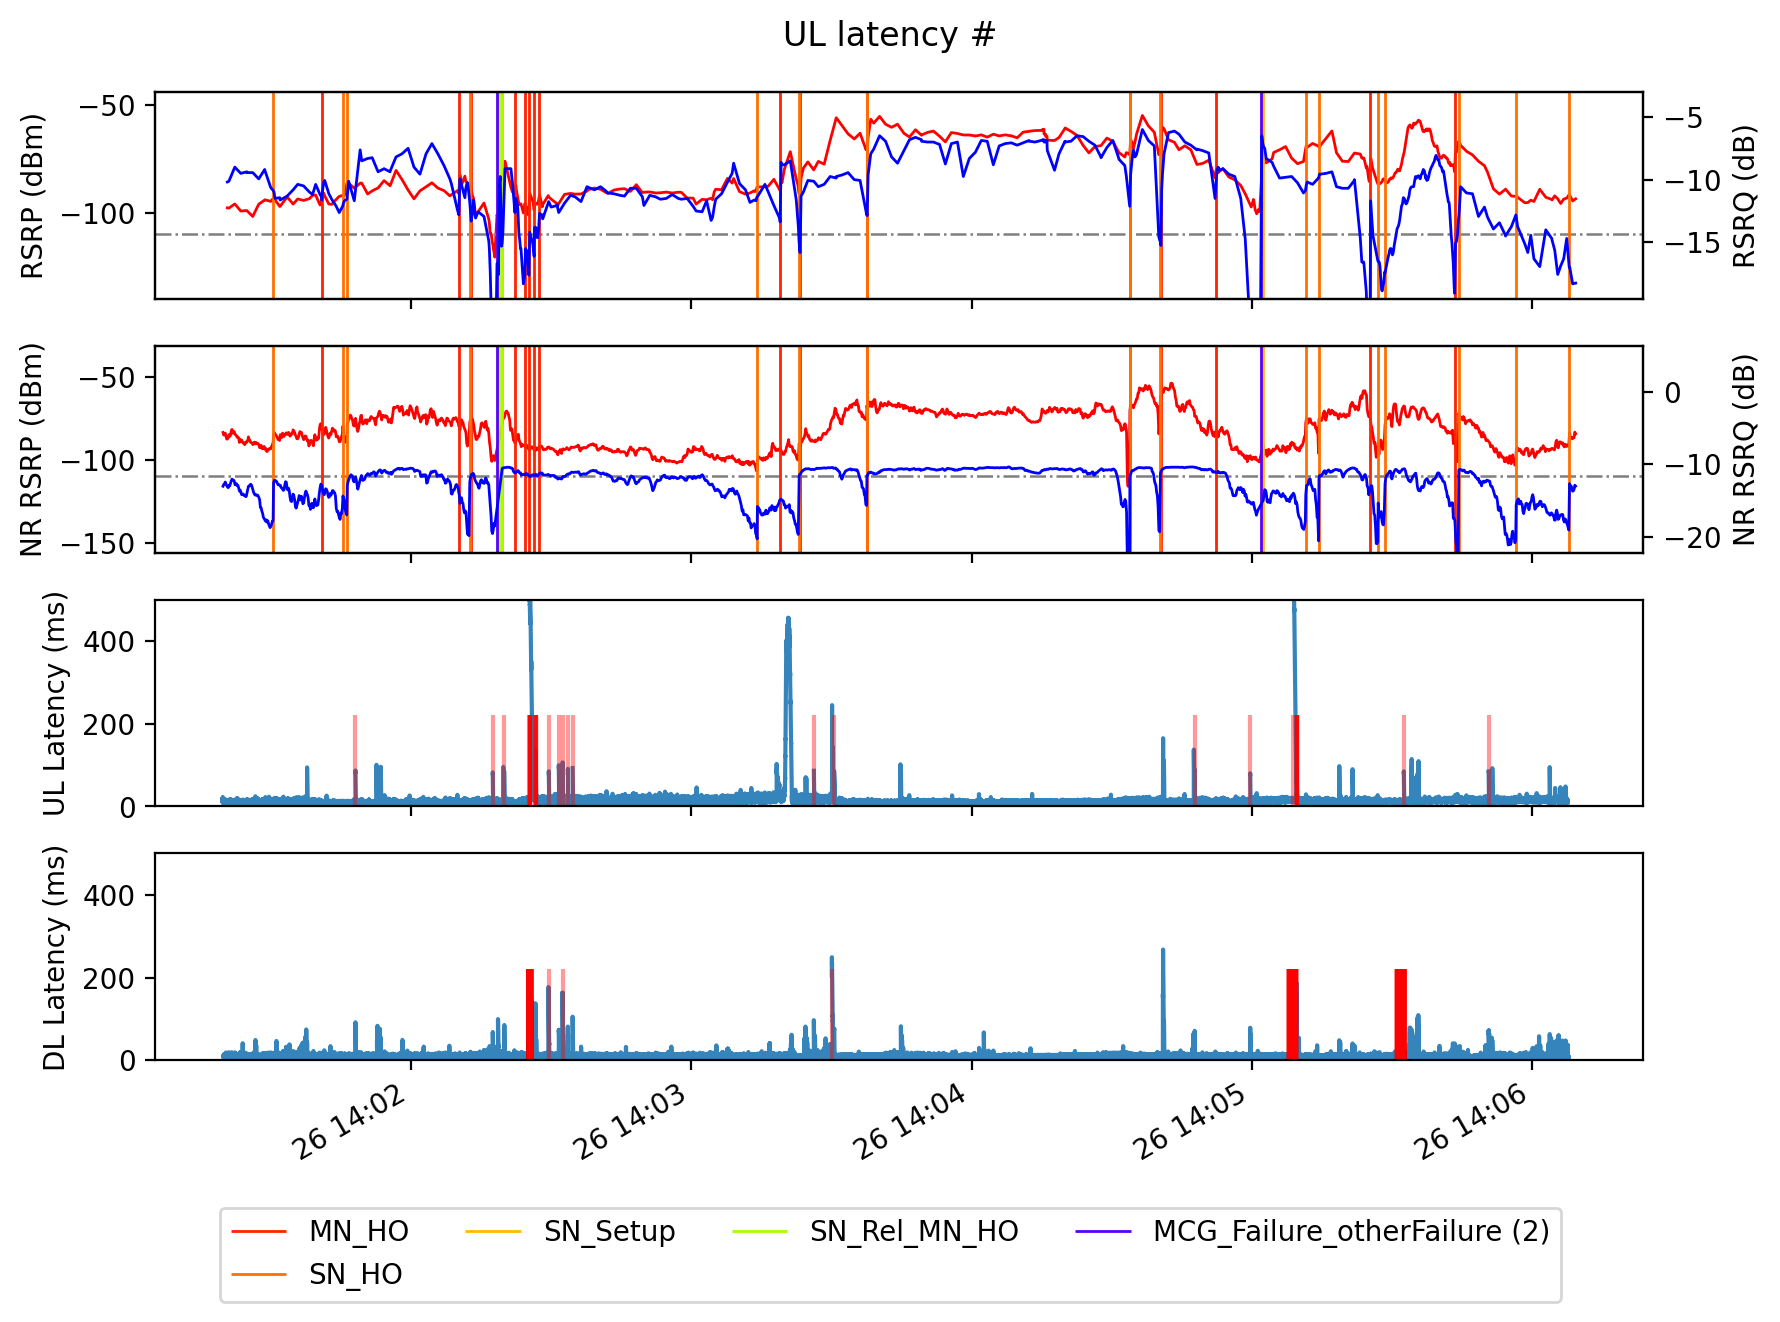

In [5]:
handover = ['LTE_HO','MN_HO','SN_HO','SN_Setup','SN_Rel','SN_Rel_MN_HO',
            'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)','SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
            'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
            'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']
# cmap = bpy_color_palette(len(handover), 0.2)
cmap = plt.cm.get_cmap('gist_rainbow', len(handover))
clist = [matplotlib.colors.to_hex(cmap(i)) for i in range(cmap.N)]
cdict = {tag:color for color, tag in zip(clist, handover)}

fig, axs = plt.subplots(4,1, figsize=(9, 6), sharex=True)
fig.suptitle('UL latency {}'.format(trace[0]))
plt.gcf().autofmt_xdate()

axs[0].set_ylim([-140, -44])
axs[0].set_ylabel('RSRP (dBm)')
x = df_pcel["Timestamp"].iloc[:]
y = df_pcel["RSRP"].iloc[:].astype(float)
# eutra_rsrp_plot, = axs[0].plot(x, y, c='r', label='LTE RSRP', linewidth=1.0)
eutra_rsrp_plot, = axs[0].plot(x, y, c='r', linewidth=1.0)
axs[0].axhline(-110, c='tab:gray', linestyle='-.', linewidth=0.9)
ax = axs[0].twinx()
ax.set_ylim([-19.5, -3])
ax.set_ylabel('RSRQ (dB)')
x = df_pcel["Timestamp"].iloc[:]
y = df_pcel["RSRQ"].iloc[:].astype(float)
# eutra_rsrq_plot, = ax.plot(x, y, c='r', label='LTE RSRQ', linewidth=1.0)
eutra_rsrq_plot, = ax.plot(x, y, c='b', linewidth=1.0)

ho_plots = []
ho_types = []
x = df_ho["Timestamp"].array
group = group = df_ho["ho_type0"].array
for tag in handover:
    indices = np.where(group == tag)[0]
    if len(indices) == 0:
        continue
    ho_types.append(tag)
    ho_plots.append(axs[0].vlines(x[indices], ymin=-140, ymax=-44, color=cdict[tag], linewidth=1.0, label=tag))

axs[1].set_ylim([-156, -31])
axs[1].set_ylabel('NR RSRP (dBm)')
x = df_pscel["Timestamp"].iloc[:]
y = df_pscel["RSRP"].iloc[:].astype(float)
# nr_rsrp_plot, = axs[1].plot(x, y, c='r', label='NR RSRP', linewidth=1.0)
nr_rsrp_plot, = axs[1].plot(x, y, c='r', linewidth=1.0)
axs[1].axhline(-110, c='tab:gray', linestyle='-.', linewidth=0.9)
ax = axs[1].twinx()
ax.set_ylim([-22.19, 6.39])
ax.set_ylabel('NR RSRQ (dB)')
x = df_pscel["Timestamp"].iloc[:]
y = df_pscel["RSRQ"].iloc[:].astype(float)
# nr_rsrq_plot, = ax.plot(x, y, c='r', label='NR RSRQ', linewidth=1.0)
nr_rsrq_plot, = ax.plot(x, y, c='b', linewidth=1.0)

x = df_ho["Timestamp"].array
group = group = df_ho["ho_type0"].array
for tag in handover:
    indices = np.where(group == tag)[0]
    if len(indices) == 0:
        continue
    axs[1].vlines(x[indices], ymin=-156, ymax=-31, color=cdict[tag], linewidth=1.0)

axs[2].set_ylim([0, 500])
axs[2].set_ylabel('UL Latency (ms)')
x = df_ul["Timestamp"].iloc[:]
y = [s*1000 for s in df_ul["latency"].iloc[:]]
axs[2].plot(x, y, label='UL Latency', alpha=0.9)
x2 = df_ul.loc[df_ul['lost'] == True, "Timestamp"].iloc[:]
axs[2].vlines(x2, ymin=0, ymax=220, color='r', label='UL Loss', alpha=0.4)

axs[3].set_ylim([0, 500])
axs[3].set_ylabel('DL Latency (ms)')
x = df_dl["Timestamp"].iloc[:]
y = [s*1000 for s in df_dl["latency"].iloc[:]]
axs[3].plot(x, y, label='DL Latency', alpha=0.9)
x2 = df_dl.loc[df_dl['lost'] == True, "Timestamp"].iloc[:]
axs[3].vlines(x2, ymin=0, ymax=220, color='r', label='DL Loss', alpha=0.4)

### adjust figure layout
handles = ho_plots
labels = ho_types

axbox = axs[3].get_position()
fig.legend(
    handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.3,1,1],
    # ncol=3,
    ncol=4,
)

fig.tight_layout()

In [33]:
group = df_ho["ho_type0"].array
indices = np.where(group == 'MN_HO')[0]
print(indices)
print(len(indices))
# indices = list(np.where(group == 'SCG_Failure_randomAccessProblem (1)')[0])
# print(indices)
# print(len(indices))

[ 0  1  3  4  5  6 10 16 17 19 21 23 30 31 34 39 40 41]
18


In [31]:
x = df_ho["Timestamp"].array
x[indices]

<DatetimeArray>
['2023-05-15 15:35:44.948907', '2023-05-15 15:35:45.594424',
 '2023-05-15 15:35:56.382042', '2023-05-15 15:35:59.978915',
 '2023-05-15 15:36:03.097011', '2023-05-15 15:36:08.302038',
 '2023-05-15 15:36:26.771990', '2023-05-15 15:36:37.265158',
 '2023-05-15 15:36:38.283122', '2023-05-15 15:36:39.980641',
 '2023-05-15 15:36:42.682983', '2023-05-15 15:37:09.925694',
 '2023-05-15 15:38:30.882165', '2023-05-15 15:38:42.634108',
 '2023-05-15 15:39:05.643376', '2023-05-15 15:39:51.192076',
 '2023-05-15 15:39:51.948875', '2023-05-15 15:39:53.965475']
Length: 18, dtype: datetime64[ns]

In [32]:
df_ho

,start,end,ho_type,intr,sPCI,sFreq,tPCI,tFreq,snrPCI,tnrPCI,cause,others,st_scel,ePCI,ECI,eNB,BID,DL_Freq,DL_BW,UL_Freq,UL_BW,ePCI1,ECI1,eNB1,BID1,DL_Freq1,DL_BW1,UL_Freq1,UL_BW1,nrPCI,nrFreq,nrPCI1,nrFreq1,Timestamp,type_id,ho_type0
2,2023-05-15 15:35:44.948907,2023-05-15 15:35:44.965425,MN_HO,0.016518,178,3050,386,3050,178,<NA>,NaN,Set up 1 SCell.,1,178,<NA>,<NA>,<NA>,3050,NaN,<NA>,NaN,386,54320654,212190,7,3050,20 MHz,21050,20 MHz,178,631000,178,631000,2023-05-15 15:35:44.948907,RRC_OTA_Handover_Parsing,MN_HO
3,2023-05-15 15:35:45.594424,2023-05-15 15:35:45.610438,MN_HO,0.016014,386,3050,178,3050,178,<NA>,NaN,Set up 1 SCell.,1,386,54320654,212190,7,3050,20 MHz,21050,20 MHz,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,178,631000,178,631000,2023-05-15 15:35:45.594424,RRC_OTA_Handover_Parsing,MN_HO
4,2023-05-15 15:35:53.314060,2023-05-15 15:35:53.328878,SN_HO,0.014818,178,3050,<NA>,<NA>,178,386,NaN,<NA>,0,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,178,631000,386,631000,2023-05-15 15:35:53.314060,RRC_OTA_Handover_Parsing,SN_HO
5,2023-05-15 15:35:56.382042,2023-05-15 15:35:56.398306,MN_HO,0.016264,178,3050,386,3050,386,<NA>,NaN,Set up 1 SCell.,1,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,386,54320654,212190,7,3050,20 MHz,21050,20 MHz,386,631000,386,631000,2023-05-15 15:35:56.382042,RRC_OTA_Handover_Parsing,MN_HO
6,2023-05-15 15:35:59.978915,2023-05-15 15:35:59.996530,MN_HO,0.017615,386,3050,178,3050,386,<NA>,NaN,Set up 1 SCell.,1,386,54320654,212190,7,3050,20 MHz,21050,20 MHz,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,386,631000,386,631000,2023-05-15 15:35:59.978915,RRC_OTA_Handover_Parsing,MN_HO
7,2023-05-15 15:36:03.097011,2023-05-15 15:36:03.113267,MN_HO,0.016256,178,3050,386,3050,386,<NA>,NaN,Set up 1 SCell.,1,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,386,54320654,212190,7,3050,20 MHz,21050,20 MHz,386,631000,386,631000,2023-05-15 15:36:03.097011,RRC_OTA_Handover_Parsing,MN_HO
8,2023-05-15 15:36:08.302038,2023-05-15 15:36:08.319395,MN_HO,0.017357,386,3050,178,3050,386,<NA>,NaN,Set up 1 SCell.,1,386,54320654,212190,7,3050,20 MHz,21050,20 MHz,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,386,631000,386,631000,2023-05-15 15:36:08.302038,RRC_OTA_Handover_Parsing,MN_HO
9,2023-05-15 15:36:16.646940,2023-05-15 15:36:16.671729,SN_HO,0.024789,178,3050,<NA>,<NA>,386,122,NaN,<NA>,0,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,386,631000,122,631000,2023-05-15 15:36:16.646940,RRC_OTA_Handover_Parsing,SN_HO
10,2023-05-15 15:36:25.428852,2023-05-15 15:36:25.470041,SN_Rel_MN_HO,0.041189,178,3050,122,3050,122,<NA>,NaN,Set up 1 SCell.,1,178,54562072,213133,7,3050,20 MHz,21050,20 MHz,122,54303522,212123,7,3050,20 MHz,21050,20 MHz,122,631000,<NA>,<NA>,2023-05-15 15:36:25.428852,RRC_OTA_Handover_Parsing,SN_Rel_MN_HO
11,2023-05-15 15:36:25.734292,2023-05-15 15:36:25.772003,SN_Setup,0.037711,122,3050,<NA>,<NA>,<NA>,122,NaN,Set up 1 SCell.,1,122,54303522,212123,7,3050,20 MHz,21050,20 MHz,122,54303522,212123,7,3050,20 MHz,21050,20 MHz,<NA>,<NA>,122,631000,2023-05-15 15:36:25.734292,RRC_OTA_Handover_Parsing,SN_Setup
